In [3]:
## Miscelaneous
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm
import pickle as pkl

import pybedtools
from pybedtools import BedTool

import subprocess

import pickle as pkl

# import chromograph
# from chromograph.peak_calling.utils import *
# from chromograph.pipeline.utils import *
# from chromograph.plotting.marker_plot import marker_plot
# from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
# from chromograph.pipeline import config

# import cytograph as cg
# from cytograph.plotting.colors import colorize
# from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
# from cytograph.species import Species

# import fisher

# from typing import *

# import matplotlib.pyplot as plt
# import matplotlib
# import numpy as np
# import scipy.stats as stats
# import scipy
# from statsmodels.sandbox.stats.multicomp import multipletests

# import logging
# logger = logging.getLogger()
# logging.basicConfig(
#     format='%(asctime)s %(levelname)-8s %(message)s',
#     level=logging.INFO,
#     datefmt='%H:%M:%S')

# config = config.load_config()

In [17]:
f = '/Users/camima/Downloads/Count00004_LBEXP20210414_EEL_HE_1990um_C1H04.pkl'
EXP = 'CMEXP20210311'

f_out = f'/Users/camima/Downloads/Count00000_{EXP}.pkl'
file = open(f, 'rb')
data = pkl.load(file)

data['experiment_name'] = EXP
data['Description'] = 'Mouse P60 Hippocampus'
data['Machine'] = 'ROBOFISH1'
data['Operator'] = 'camiel'
data['Species'] = 'Mus Musculus'
data['Sample'] = 'BL670'
data['Age'] = 'P60'
data['channels'] = {'Code': 'C1H04',
  'Chamber': 1,
  'Hybridization': 'Hybridization00',
  'DAPI': 'DAPI',
  'Atto425': 'None',
  'FITC': 'mKi67',
  'Cy3': 'FoxO6',
  'TxRed': 'FoxO3',
  'Cy5': 'Nes',
  'Cy7': 'None',
  'QDot': 'None',
  'BrightField': 'None',
  'Europium': 'None'}

pkl.dump(data, open(f_out,"wb"))

In [13]:
data

{'round_code': 'C1H04',
 'experiment_name': 'LBEXP20210414_EEL_HE_1990um',
 'Description': 'Human Embryo 7weeks EEL atlas section 2260um',
 'Protocols_io': 'https://www.protocols.io/edit/eel-t92er8e',
 'chamber': 'chamber1',
 'Machine': 'ROBOFISH2',
 'Operator': 'lars',
 'Timestamp_robofish': '2021-04-17 21-43-04',
 'hybridization_fname': 'Unknown-at-dict-generation-time',
 'hybridization_number': 4,
 'Hyb_time_A': 0.16,
 'Hyb_time_B': 'None',
 'Hyb_time_C': 'None',
 'Hybmix_volume': 500,
 'Imaging_temperature': 20.0,
 'Fluidic_Program': 'EEL_barcoded',
 'Readout_temperature': 22.0,
 'Staining_temperature': 37.0,
 'Start_date': '20210414',
 'Target_cycles': 16,
 'Species': 'Homo sapiens',
 'Sample': 'HE20 or BRC2152',
 'Strain': 'None',
 'Age': '7W1D PCA',
 'Tissue': 'Head',
 'Orrientation': 'Saggital',
 'RegionImaged': 'Head',
 'SectionID': '1990um',
 'Position': 'None',
 'Experiment_type': 'eel-barcoded',
 'Chemistry': 'EELV2_corev2',
 'Probe_FASTA_name': 'HE.fasta',
 'Barcode': 'Tru

In [3]:
file = '/proj/DEV_ATAC/PBMC_test/All/peaks/1.pkl'

Counts = pkl.load(open(file, 'rb'))

In [8]:
import loompy
import os
import subprocess
import gc
import sys
import numpy as np
from datetime import datetime
import logging
from typing import *
from tqdm import tqdm

import pickle as pkl
import gzip
import glob
import pybedtools
from pybedtools import BedTool
import shutil
import multiprocessing as mp
from pynndescent import NNDescent

## Import chromograph
import chromograph
from chromograph.pipeline.Bin_analysis import *
from chromograph.pipeline import config
from chromograph.pipeline.utils import transfer_ca, div0
from chromograph.features.GA_Aggregator import GA_Aggregator
from chromograph.peak_calling.peak_caller import *
from chromograph.peak_calling.utils import *

config = config.load_config()

## Setup logger and load config
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [36]:
def generate_prom_matrix(file_5kb, gene_ref, peakdir, sample_dir, verbose=False):
    name = file_5kb.split('/')[-1].split('_')[0]
    loom_file = f"/{os.path.join(*file_5kb.split('/')[:-1])}/{name}_prom.loom"

    if verbose:
        logging.info(f"Start counting TSS enrichment for {name}")
    
    with loompy.connect(file_5kb, 'r') as ds:
        chunks = np.array_split(ds.ca['CellID'], np.int(np.ceil(ds.shape[1]/100)))
        dict_files = glob.glob(os.path.join(peakdir, '*.pkl'))

        if len(chunks) > len(dict_files):
            if verbose:
                logging.info(f'Using {min(mp.cpu_count(), len(chunks))} cores')
            with mp.get_context().Pool(min(mp.cpu_count(), len(chunks)), maxtasksperchild=10) as pool:
                for i, cells in enumerate(chunks):
                    pool.apply_async(Count_peaks, args=(i, cells, sample_dir, peakdir, gene_ref, 'genes',))
                pool.close()
                pool.join()

        ## Generate row attributes
        if verbose:
            logging.info("Generating row attributes")
        row_attrs = {k: [] for k in ['Accession', 'Gene', 'loc', 'BPs']}
        for x in BedTool(gene_ref):
            row_attrs['Accession'].append(x.attrs['gene_id'])
            row_attrs['Gene'].append(x.attrs['gene_name'])
            row_attrs['loc'].append(f'{x[0]}:{x[3]}-{x[4]}')
            row_attrs['BPs'].append(int(abs(int(x[3])-int(x[4]))))

        r_dict = {k: v for v,k in enumerate(row_attrs['Accession'])} 

        if verbose:
            logging.info("Generating Sparse matrix")
        col = []
        row = []
        v = []

        cix = 0
        IDs = []
        dict_files = sorted(glob.glob(os.path.join(peakdir, '*.pkl')))
        for file in dict_files:
            Counts = pkl.load(open(file, 'rb'))
            for cell in Counts:
                if len(Counts[cell]) > 0:
                    for key in (Counts[cell]):
                        col.append(cix)
                        row.append(r_dict[key])
                        v.append(np.int8(Counts[cell][key]))
                cix+=1
                IDs.append(cell)

        matrix = sparse.coo_matrix((v, (row,col)), shape=(len(r_dict.keys()), len(ds.ca['CellID']))).tocsc()        
        if verbose:
            logging.info(f'Matrix has shape {matrix.shape} with {matrix.nnz} elements')

        ## Create loomfile
        if verbose:
            logging.info("Constructing loomfile")
        
        loompy.create(filename=loom_file, 
                    layers=matrix, 
                    row_attrs=row_attrs, 
                    col_attrs={'CellID': np.array(IDs)},
                    file_attrs=dict(ds.attrs))
        
        ## Remove pkls
        if verbose:
            logging.info("Deleting pkl files")
        for f in dict_files:
            os.system(f'rm {f}') 
        if verbose:
            logging.info(f"Finished with {name}")
        
            
file_5kb = '/datb/sl/camiel/scATAC/samples/10XPBMC/10XPBMC_5kb.loom'
gene_ref = os.path.join(chromograph.__path__[0], 'references/GRCh38_2kbprom.bed')
peakdir = '/proj/DEV_ATAC/PBMC_test/All/peaks/'

generate_prom_matrix(file_5kb, gene_ref, peakdir, config.paths.samples)

/datb/sl/camiel/scATAC/samples/10XPBMC/10XPBMC_prom.loom


In [31]:
f = '/proj/DEV_ATAC/PBMC_test/All/All_peaks.loom'
# f = '/proj/DEV_ATAC/Build_20210203/All/All_peaks.loom'

output_file = 

with loompy.connect(f, 'r') as ds:
    logging.info(f'Check if promoter files exist')
    inputfiles = [os.path.join(config.paths.samples, sample, f"{sample}_prom.loom") for sample in np.unique(ds.ca.Name)]
    selections = []
    for file in inputfiles:
        ## Check if file with right binning exists
        if not os.path.exists(file):
            file_5kb = glob.glob(f"/{os.path.join(*file.split('/')[:-1])}/*5kb.loom")[0]
            generate_prom_matrix(file_5kb, gene_ref, peakdir, config.paths.samples)

        ## Get cells passing filters
        with loompy.connect(file, 'r') as ds2:
            good_cells = [x in ds.ca.CellID for x in ds2.ca.CellID]
            selections.append(good_cells)
            
    logging.info(f'Combining samples')
    loompy.combine_faster(inputfiles, output_file, selections=selections, key = 'loc')

13:50:35 INFO     Check if promoter files exist


/datb/sl/camiel/scATAC/samples/10XPBMC/10XPBMC_5kb.loom
True


In [38]:
f1 = '/proj/DEV_ATAC/PBMC_test/All/All.loom'
f2 = '/datb/sl/camiel/scATAC/samples/10XPBMC/10XPBMC_20kb.loom'

with loompy.connect(f1, 'r') as ds:
    with loompy.connect(f2, 'r') as ds2:
        good_cells = [x in ds.ca.CellID for x in ds2.ca.CellID]
        
        logging.info(f"total: {len(good_cells)}, valid: {np.sum(good_cells)}")

14:52:07 INFO     total: 9055, valid: 8592


In [41]:
from chromograph.peak_calling.utils import *

def generate_peak_matrix(id, cells, sample_dir, peak_dir, annot, verbose=False):
    '''
    '''
    Count_peaks(id, cells, sample_dir, peak_dir, os.path.join(peak_dir, 'Compounded_peaks.bed'))
    
    if verbose:
        logging.info("Generating Sparse matrix")
    col = []
    row = []
    v = []
    cix = 0
    IDs = []


    # Order dict for rows
    r_dict = {k: v for v,k in enumerate(annot['ID'])}

    ## Generate sparse peak lists
    file = open(os.path.join(peak_dir, f'{id}.pkl'))
    Counts = pkl.load(open(file, 'rb'))
    for cell in Counts:
        if len(Counts[cell]) > 0:
            for key in (Counts[cell]):
                col.append(cix)
                row.append(r_dict[key])
                v.append(np.int8(Counts[cell][key]))
        cix+=1
        IDs.append(cell)

    ## Convert to sparse matrix
    matrix = sparse.coo_matrix((v, (row,col)), shape=(len(r_dict.keys()), len(ds.ca['CellID']))).tocsc()
    if verbose:
        logging.info(f'Matrix has shape {matrix.shape} with {matrix.nnz} elements')
        logging.info(f'Generating temporary loom file')

    ## Create loomfile
    logging.info("Constructing loomfile")
    loom_file = os.path.join(self.outdir, f'{id}_peaks.loom')

    loompy.create(filename=loom_file, 
                layers=matrix, 
                row_attrs=annot, 
                col_attrs={'CellID': np.array(IDs)})
    return

In [ ]:
f = '/proj/DEV_ATAC/Build_20210126_ATAC/All/All_copy.loom'
f_annot = '/proj/DEV_ATAC/Build_20210126_ATAC/All/peaks/annotated_peaks.txt'
sample_dir = '/datb/sl/camiel/scATAC/samples/'
peak_dir = '/proj/DEV_ATAC/Build_20210126_ATAC/All/peaks/'

logging.info(f'Reordering annotation file')
cols, table = read_HOMER_annotation(f_annot)
peaks_all = BedTool(os.path.join(peak_dir, 'Compounded_peaks.bed'))
peak_IDs = np.array([x[3] for x in peaks_all])
table = reorder_by_IDs(table, peak_IDs)
annot = {cols[i]: table[:,i] for i in range(table.shape[1])}

with loompy.connect(f) as ds:
    logging.info(f'Start counting peaks')
    chunks = np.array_split(ds.ca['CellID'], np.int(np.ceil(ds.shape[1]/100)))
    r_dict = {k: v for v,k in enumerate(annot['ID'])}
    generate_peak_matrix(0, chunks[0], sample_dir, peak_dir, r_dict, verbose=True)

12:19:18 INFO     Reordering annotation file


In [45]:
with loompy.connect(f, 'r') as ds:
    X = ds.ca.passed_filters

(array([ 1.,  7., 13., 19., 26., 19., 11.,  2.,  1.,  1.]),
 array([21204324. , 21535747.2, 21867170.4, 22198593.6, 22530016.8,
        22861440. , 23192863.2, 23524286.4, 23855709.6, 24187132.8,
        24518556. ]),
 <BarContainer object of 10 artists>)

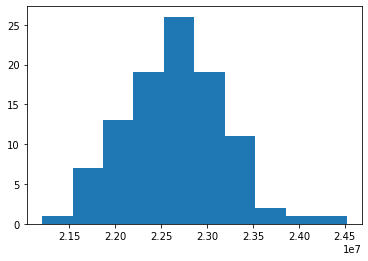

In [53]:
Y = []
N = 1000

for i in range(100):
    Y.append(np.sum(np.random.choice(X, size=N, replace=False)))
    
plt.hist(Y)

In [14]:
def f(x):
    return x*x

if __name__ == '__main__':
    # start 4 worker processes
    with mp.Pool(processes=4) as pool:

        # print "[0, 1, 4,..., 81]"
        print(pool.map(f, range(10)))

        # print same numbers in arbitrary order
        for i in pool.imap_unordered(f, range(10)):
            print(i)

        # evaluate "f(20)" asynchronously
        res = pool.apply_async(f, (20,))      # runs in *only* one process
        print(res.get(timeout=1))             

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
0
1
4
9
16
25
36
49
64
81
400


In [34]:
# dir = config.paths.samples
dir = os.path.join('/proj/DEV_ATAC/GBM_20210128/All/')
files = os.listdir(dir)
for f in files:
    if f.split('.')[-1] == 'loom':
        if not f.split('.')[-2] == 'agg':
            print(f)
            with loompy.connect(os.path.join(dir, f), 'r+') as ds:
                ds.ca.FRprom = ds.ca.promoter_region_fragments/ds.ca.passed_filters            
                ds.ca.FRIP = ds.ca.NPeaks/ds.ca.passed_filters

All.loom
All_peaks.loom
All_prom.loom
All_motifs.loom


In [2]:
# f = '/proj/DEV_ATAC/GBM_20210120/All/All_peaks.loom'
f = '/proj/DEV_ATAC/Build_20200925/All/All_peaks.loom'
poisson_pooling = False

with loompy.connect(f, 'r') as ds:
    labels = ds.ca.Shortname
    FR_prom = ds.ca.promoter_region_fragments/ds.ca.passed_filters
    FRIP = ds.ca.NPeaks/ds.ca.passed_filters

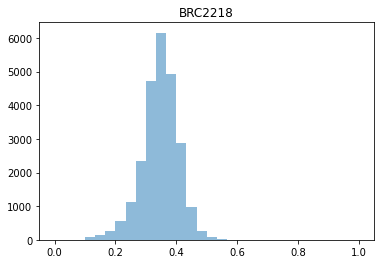

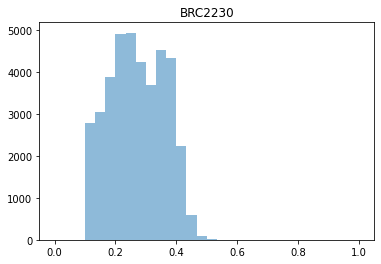

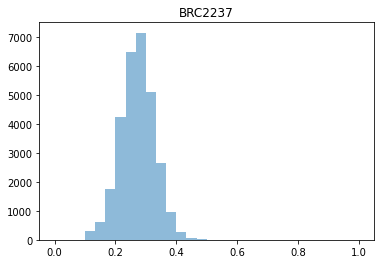

In [3]:
for label in np.unique(labels):
    k = np.where(labels == label)[0]
    plt.figure()
    plt.hist(FR_prom[k], bins = 30, alpha=0.5, range=(0,1))
    plt.title(label)

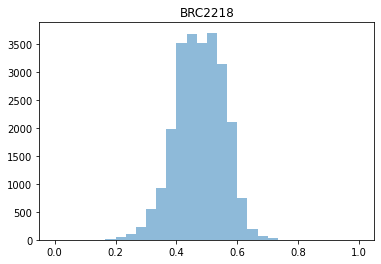

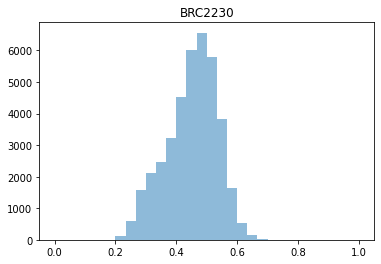

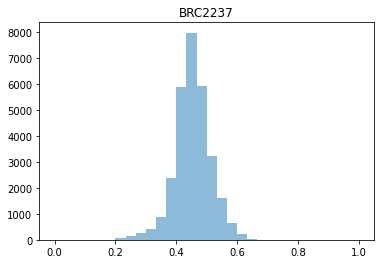

In [51]:
for label in np.unique(labels):
    k = np.where(labels == label)[0]
    plt.figure()
    plt.hist(FRIP[k], bins = 30, alpha=0.5, range=(0,1))
    plt.title(label)

In [5]:
from chromograph.peak_calling.utils import read_HOMER_TFs

f = '/proj/DEV_ATAC/GBM_20200908/All/All_peaks.loom'
f2 = '/proj/DEV_ATAC/GBM_20200908/All/All_motifs.loom'
peakdir = '/proj/DEV_ATAC/GBM_20200908/All/peaks'

with loompy.connect(f) as ds:
    ## Load the annotated peaks
    cols, table, TF_cols, TFs = read_HOMER_TFs(os.path.join(peakdir, 'motif_annotation.txt'))
    logging.info(f'Creating a loom-file to fill with enrichments of {len(TF_cols)} motifs for {ds.shape[1]} cells')

    with loompy.new(f2) as dsout:
        ## Transferring column attributes and graphs from peak-file
        dsout.add_columns(np.zeros([TFs.shape[1], ds.shape[1]]), col_attrs=ds.ca, row_attrs={'Gene': np.array([x.split('_')[0] for x in TF_cols]), 'Total_peaks': np.array(np.sum(TFs, axis = 0))})
        dsout.col_graphs = ds.col_graphs
        logging.info(f'New loom file has shape {dsout.shape}')
        print(dsout.col_graphs.keys())

21:32:45 INFO     Creating a loom-file to fill with enrichments of 401 motifs for 14932 cells
21:32:47 INFO     New loom file has shape (401, 14932)


['KNN', 'MKNN', 'RNN']


In [30]:
file_m = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.mtx'
file_b = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt.gz'
file_p = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.peaks.txt.gz'

mat = scipy.io.mmread(file_m)

In [31]:
import pandas as pd
barcodes = pd.read_table(file_b)
peaks = pd.read_csv(file_p)


In [32]:
col_attrs = {k: np.array(barcodes[k]) for k in barcodes}
del row_attrs

for x in peaks['Feature']:
    if 'row_attrs' not in locals():
        row_attrs = {}
        chrom, start, end = x.split('_')
        row_attrs['ID'] = [f'{chrom}:{start}-{end}']
        row_attrs['Chr'] = [chrom]
        row_attrs['Start'] = [start]
        row_attrs['End'] = [end]
    else:
        chrom, start, end = x.split('_')
        row_attrs['ID'].append(f'{chrom}:{start}-{end}')
        row_attrs['Chr'].append(chrom)
        row_attrs['Start'].append(start)
        row_attrs['End'].append(end)

In [33]:
filename = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.loom'

loompy.create(filename, mat, row_attrs, col_attrs)

In [43]:
from chromograph.peak_analysis.utils import *

filename = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.loom'
out_file = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.agg.loom'

agg_spec = {
    "Group": "tally",
    "Clusters": "first",
    "FRIP": "mean",
    "depth": "mean"
}

with loompy.connect(filename) as ds:
    ds.ca.Clusters = np.array([int(x.strip('Cluster')) for x in ds.ca.Clusters])
    ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:

        logging.info('Calculate coverage metrics')
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Call positive and negative peaks for every cluster
        dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)


19:39:35 INFO     Calculate coverage metrics
19:39:41 INFO     Convert to CPMs
19:39:44 INFO     Binarize peak matrix
100%|██████████| 31/31 [00:26<00:00,  1.15it/s]


14:37:01 INFO     Shape (571400, 31)


0

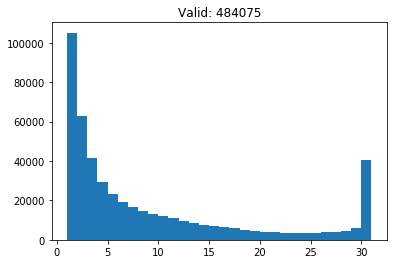

In [109]:
threshold = 1

out_file = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.agg.loom'
bed_file = '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg19.bed'
lifted_file = '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg38.bed'
unlifted = '/fish/other_tmp/camiel_tmp/Greenleaf/unlifted.bed'
with loompy.connect(out_file) as dsagg:
    logging.info(f'Shape {dsagg.shape}')
    Valids = []
    binary = dsagg['CPM'][:,:] > threshold
    ON = np.sum(binary[:,:], axis=1)
    Valids = ON > 0
    plt.figure()
    plt.title(f'Valid: {np.sum(Valids)}')
    plt.hist(ON[Valids], bins= 30)
    
with loompy.connect(out_file) as ds:
    enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)
    
subprocess.call(['/home/camiel/anaconda3/envs/DNA_tools/bin/liftOver', bed_file, '/data/proj/scATAC/ref/hg19ToHg38.over.chain.gz', lifted_file, unlifted])
subprocess.call(['rm', unlifted])

## Lake data

In [ ]:
from scipy import sparse

for Tissue in ['Fcx1', 'Occ1', 'Cbh1']:

    logging.info(f'Start on tissue: {Tissue}')

    ## Recovering matrix from bam files
    f_dir = f'/fish/other_tmp/camiel_tmp/Lake/{Tissue}/bams'
    files = os.listdir(f_dir)

    barcodes = []
    Counts = {}
    peak_dict ={}

    with open(os.path.join(f_dir, files[0])) as fi:
        for i, line in enumerate(fi):
            if i > 0:
                peak_dict[line.split()[0]] = i - 1

    cnt = 0
    for f in files:
        b = f'{f.split(".")[0]}_{f.split(".")[2].split("_")[0]}'
        if b.endswith('H'):
            b = b.strip('H')
        barcodes.append(b)
        with open(os.path.join(f_dir, f)) as fi:
            for i, line in enumerate(fi):
                if i > 0:
                    fields = line.split()
                    count = int(fields[1])
                    if count > 0:
                        if b not in Counts:
                            Counts[b] = {fields[0]:fields[1]}
                        else:
                            Counts[b][fields[0]] = fields[1]
        cnt += 1
        if cnt%2000==0:
            logging.info(cnt)

    annot = {'ID': np.array([x for x in peak_dict])}

    c, s, e = [[],[],[]]
    for x in annot['ID']:
        chrom, loc = [k.split('-') for k in x.split(':')]
        c.append(chrom[0])
        s.append(loc[0])
        e.append(loc[1])

    annot['Chr'], annot['Start'], annot['End'] = [np.array(x) for x in [c, s, e]]

    meta = np.loadtxt('/fish/other_tmp/camiel_tmp/Lake/Lake_metadata.csv', delimiter=';', skiprows=1, dtype=str)
    cols = {'barcode':np.array(meta[:,0]), 'Shortname':np.array(meta[:,3]), 'Tissue':np.array(meta[:,4]), 'Clusters':np.array(meta[:,6]), 'Clusters2':np.array(meta[:,5])}

    logging.info("Generating Sparse matrix")
    col = []
    row = []
    v = []
    cix = 0
    IDs = []
    for cell in Counts:
        if cell in cols['barcode']:
            if len(Counts[cell]) > 0:
                for key in (Counts[cell]):
                    col.append(cix)
                    row.append(peak_dict[key])
                    v.append(np.int8(Counts[cell][key]))
                cix+=1
                IDs.append(cell)

    matrix = sparse.coo_matrix((v, (row,col)), shape=(len(peak_dict.keys()), cix)).tocsc()
    logging.info(f'Matrix has shape {matrix.shape} with {matrix.nnz} elements')

    Valid = [x in IDs for x in cols['barcode']]
    cols = {k: cols[k][Valid] for k in cols}
    cols['CellID'] = np.array([f'{cols["Shortname"][x]}:{cols["barcode"][x]}' for x in range(len(cols['barcode']))])
    ID_dict = {k: v for v, k in enumerate(IDs)}
    reorder = [ID_dict[k] for k in cols['barcode']]
    cols = {k: cols[k][reorder] for k in cols}

    out_file = f'/fish/other_tmp/camiel_tmp/Lake/{Tissue}/Lake_{Tissue}.loom'
    loompy.create(filename=out_file, 
                  layers=matrix, 
                  row_attrs=annot, 
                  col_attrs=cols)
    logging.info(f'Saved file as {out_file}')

18:57:01 INFO     Start on tissue: Fcx1
19:03:05 INFO     2000
19:09:24 INFO     4000
19:15:27 INFO     6000
19:20:52 INFO     8000
19:20:57 INFO     Generating Sparse matrix
19:21:01 INFO     Matrix has shape (287381, 6630) with 1190710 elements
19:21:42 INFO     Saved file as /fish/other_tmp/camiel_tmp/Lake/Fcx1/Lake_Fcx1.loom
19:21:42 INFO     Start on tissue: Occ1
19:27:10 INFO     2000
19:32:34 INFO     4000
19:38:30 INFO     6000
19:44:15 INFO     8000
19:49:47 INFO     10000
19:55:47 INFO     12000
20:01:26 INFO     14000
20:03:52 INFO     Generating Sparse matrix
20:04:10 INFO     Matrix has shape (287381, 14870) with 8864408 elements


In [ ]:
files = [os.path.join('/fish/other_tmp/camiel_tmp/Lake/', Tissue, f'Lake_{Tissue}.loom') for Tissue in ['Fcx1', 'Occ1', 'Cbh1']]
merge_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.loom'

loompy.combine_faster(files, merge_file)

In [ ]:
out_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.agg.loom'
merge_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.loom'
agg_spec = {
    "Group": "Tissue",
    "Clusters": "first",
    "ClusterNames": "first",
    "Shortname": "tally"
}

with loompy.connect(merge_file) as ds:
    ds.ca.ClusterNames = ds.ca.Clusters
    enum = {k:v for v, k in enumerate(np.unique(ds.ca.ClusterNames))}
    ds.ca.Clusters = np.array([enum[x] for x in ds.ca.ClusterNames])
    ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:

        logging.info('Calculate coverage metrics')
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Call positive and negative peaks for every cluster
        dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)


In [ ]:
threshold = 1

out_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.agg.loom'
bed_file = '/fish/other_tmp/camiel_tmp/Lake/active_elements.hg38.bed'
with loompy.connect(out_file) as dsagg:
    logging.info(f'Shape {dsagg.shape}')
    Valids = []
    binary = dsagg['CPM'][:,:] > threshold
    ON = np.sum(binary[:,:], axis=1)
    Valids = ON > 0
    plt.figure()
    plt.title(f'Valid: {np.sum(Valids)}')
    plt.hist(ON[Valids], bins= 30)
    
with loompy.connect(out_file) as ds:
    enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)

In [ ]:
with loompy.connect(out_file) as ds:
    print(ds.ra.Chr[:10])

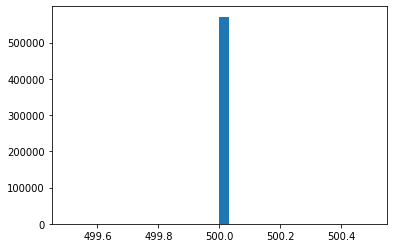

In [4]:
out_file = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.agg.loom'

with loompy.connect(out_file) as dsagg:
    plt.hist(dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int'), bins=30)

In [41]:
## Export for Cicero test
from scipy.io import mmwrite

f_ds = '/proj/DEV_ATAC/Build_20200903/Cerebellum/Cerebellum_peaks.loom'
f_peaks = '/proj/DEV_ATAC/misc/Cerebellum_peaks.bed'

with loompy.connect(f_ds) as ds:
#     X = ds['Binary'].sparse()
    BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x])) for x in range(ds.shape[0])]).saveas(f_peaks)
    
# f = '/proj/DEV_ATAC/misc/Cerebellum_peaks.mtx'
# mmwrite(f, X)

In [40]:
f_ds = '/proj/DEV_ATAC/Build_20200903/Cerebellum/Cerebellum_peaks.loom'
f_cellinfo =  '/proj/DEV_ATAC/misc/cellinfo.txt'

with loompy.connect(f_ds) as ds:
    with open(f_cellinfo, "w") as f:
        ca = "CellID"
        f.write(ca + "\t")
        for v in ds.ca[ca]:
            f.write(str(v) + "\t")
        f.write("\n")
        
        ca = "TSNE"
        for x in range(2):
            f.write(ca + f"{x}\t")
            for v in ds.ca[ca]:
                f.write(str(v[x]) + "\t")
            f.write("\n")

int8


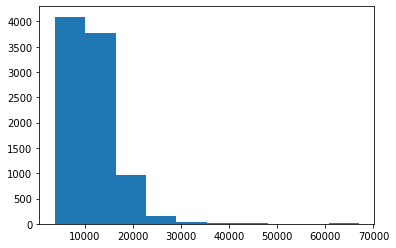

In [12]:
## Test change layer

f = '/datb/sl/camiel/scATAC/samples/test/10XPBMC_5kb.loom'

with loompy.connect(f) as ds:
    print(ds.layers[''].dtype)
    X = ds.map([np.count_nonzero], axis=1)[0]
#     ds.layers[''] = ds.layers[''][:,:].astype('int8')
#     print(ds.layers[''].dtype)

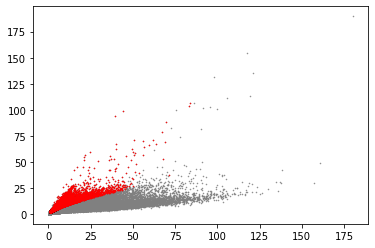

In [8]:
f = '/proj/DEV_ATAC/GBM_20210120/All/All_peaks.loom'

with loompy.connect(f, 'r') as ds:
        
    ## Plot the variance an clustermeans used for feature selection
    plt.scatter(ds.ra.mu, ds.ra.sd, s=1, c='grey', marker='.')
    plt.scatter(ds.ra.mu[np.where(ds.ra.Valid)], ds.ra.sd[np.where(ds.ra.Valid)], s=1, c='red', marker='.')

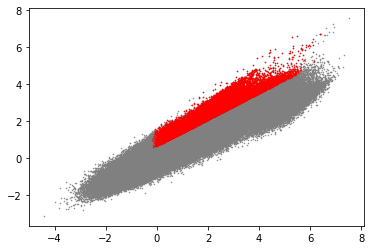

In [10]:
f = '/proj/DEV_ATAC/GBM_20210120/All/All_peaks.loom'

with loompy.connect(f, 'r') as ds:

    ## Plot the variance an clustermeans used for feature selection
    plt.scatter(np.log2(ds.ra.mu), np.log2(ds.ra.sd), s=1, c='grey', marker='.')
    plt.scatter(np.log2(ds.ra.mu[np.where(ds.ra.Valid)]), np.log2(ds.ra.sd[np.where(ds.ra.Valid)]), s=1, c='red', marker='.')

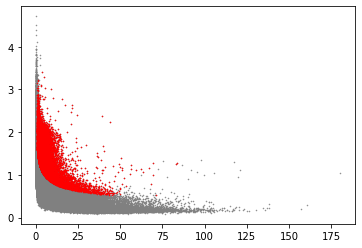

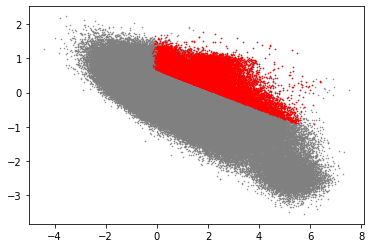

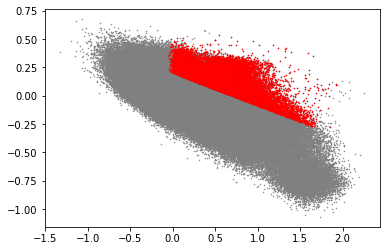

In [12]:
f = '/proj/DEV_ATAC/GBM_20210120/All/All_peaks.loom'

with loompy.connect(f, 'r') as ds:
    
    cv = ds.ra.sd/ds.ra.mu

    ## Plot the variance an clustermeans used for feature selection
    plt.scatter(ds.ra.mu, cv, s=1, c='grey', marker='.')
    plt.scatter(ds.ra.mu[np.where(ds.ra.Valid)], cv[np.where(ds.ra.Valid)], s=1, c='red', marker='.')
    
    plt.figure()
    ## Plot the variance an clustermeans used for feature selection
    plt.scatter(np.log2(ds.ra.mu), np.log2(cv), s=1, c='grey', marker='.')
    plt.scatter(np.log2(ds.ra.mu[np.where(ds.ra.Valid)]), np.log2(cv[np.where(ds.ra.Valid)]), s=1, c='red', marker='.')
    
    plt.figure()
    ## Plot the variance an clustermeans used for feature selection
    plt.scatter(np.log10(ds.ra.mu), np.log10(cv), s=1, c='grey', marker='.')
    plt.scatter(np.log10(ds.ra.mu[np.where(ds.ra.Valid)]), np.log10(cv[np.where(ds.ra.Valid)]), s=1, c='red', marker='.')

(407619, 93347)
12871


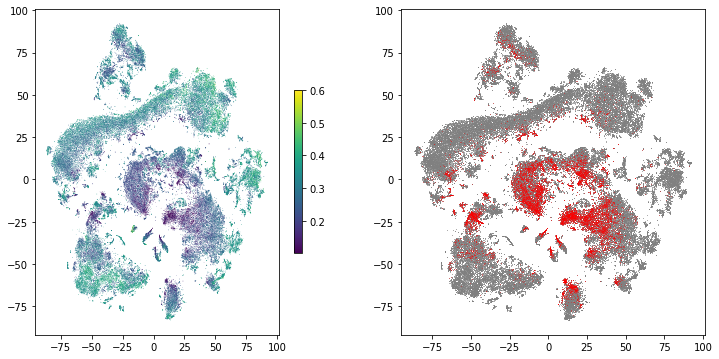

In [35]:
# f = '/proj/DEV_ATAC/GBM_20210120/All/All_peaks.loom'
f = '/proj/DEV_ATAC/Build_20200925/All/All_peaks.loom'
embedding = 'TSNE'
X=0.2

with loompy.connect(f, 'r') as ds:
    FR_tss = ds.ca.promoter_region_fragments/ds.ca.passed_filters
    
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax = ax.flatten()
    im = ax[0].scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], cmap='viridis', c=FR_tss, marker='.', lw=0, s=1)
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    
    ax[1].scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], c='gray', marker='.', lw=0, s=2)
    ax[1].scatter(ds.ca[embedding][FR_tss<X,0],ds.ca[embedding][FR_tss<X,1], c='red', marker='.', lw=0, s=1)

    print(ds.shape)
    print(np.sum(FR_tss<X))

(407619, 93347)
557


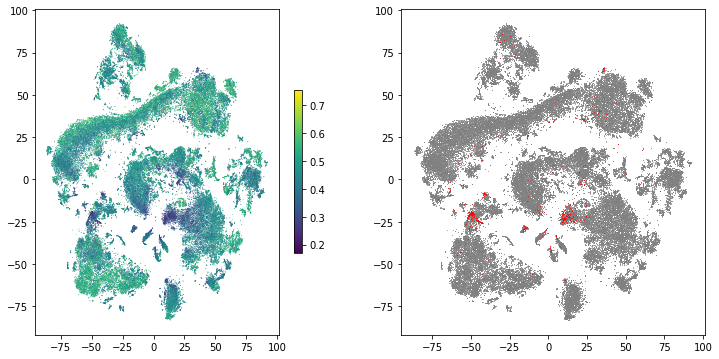

In [9]:
# f = '/proj/DEV_ATAC/GBM_20210120/All/All_peaks.loom'
f = '/proj/DEV_ATAC/Build_20200925/All/All_peaks.loom'
embedding = 'TSNE'
X = 0.25

with loompy.connect(f, 'r') as ds:
    FRIP = ds.ca.NPeaks/ds.ca.passed_filters
    
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax = ax.flatten()
    im = ax[0].scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], cmap='viridis', c=FRIP, marker='.', lw=0, s=2)
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    
    ax[1].scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], c='gray', marker='.', lw=0, s=2)
    ax[1].scatter(ds.ca[embedding][FRIP<X,0],ds.ca[embedding][FRIP<X,1], c='red', marker='.', lw=0, s=2)

    print(ds.shape)
    print(np.sum(FRIP<X))

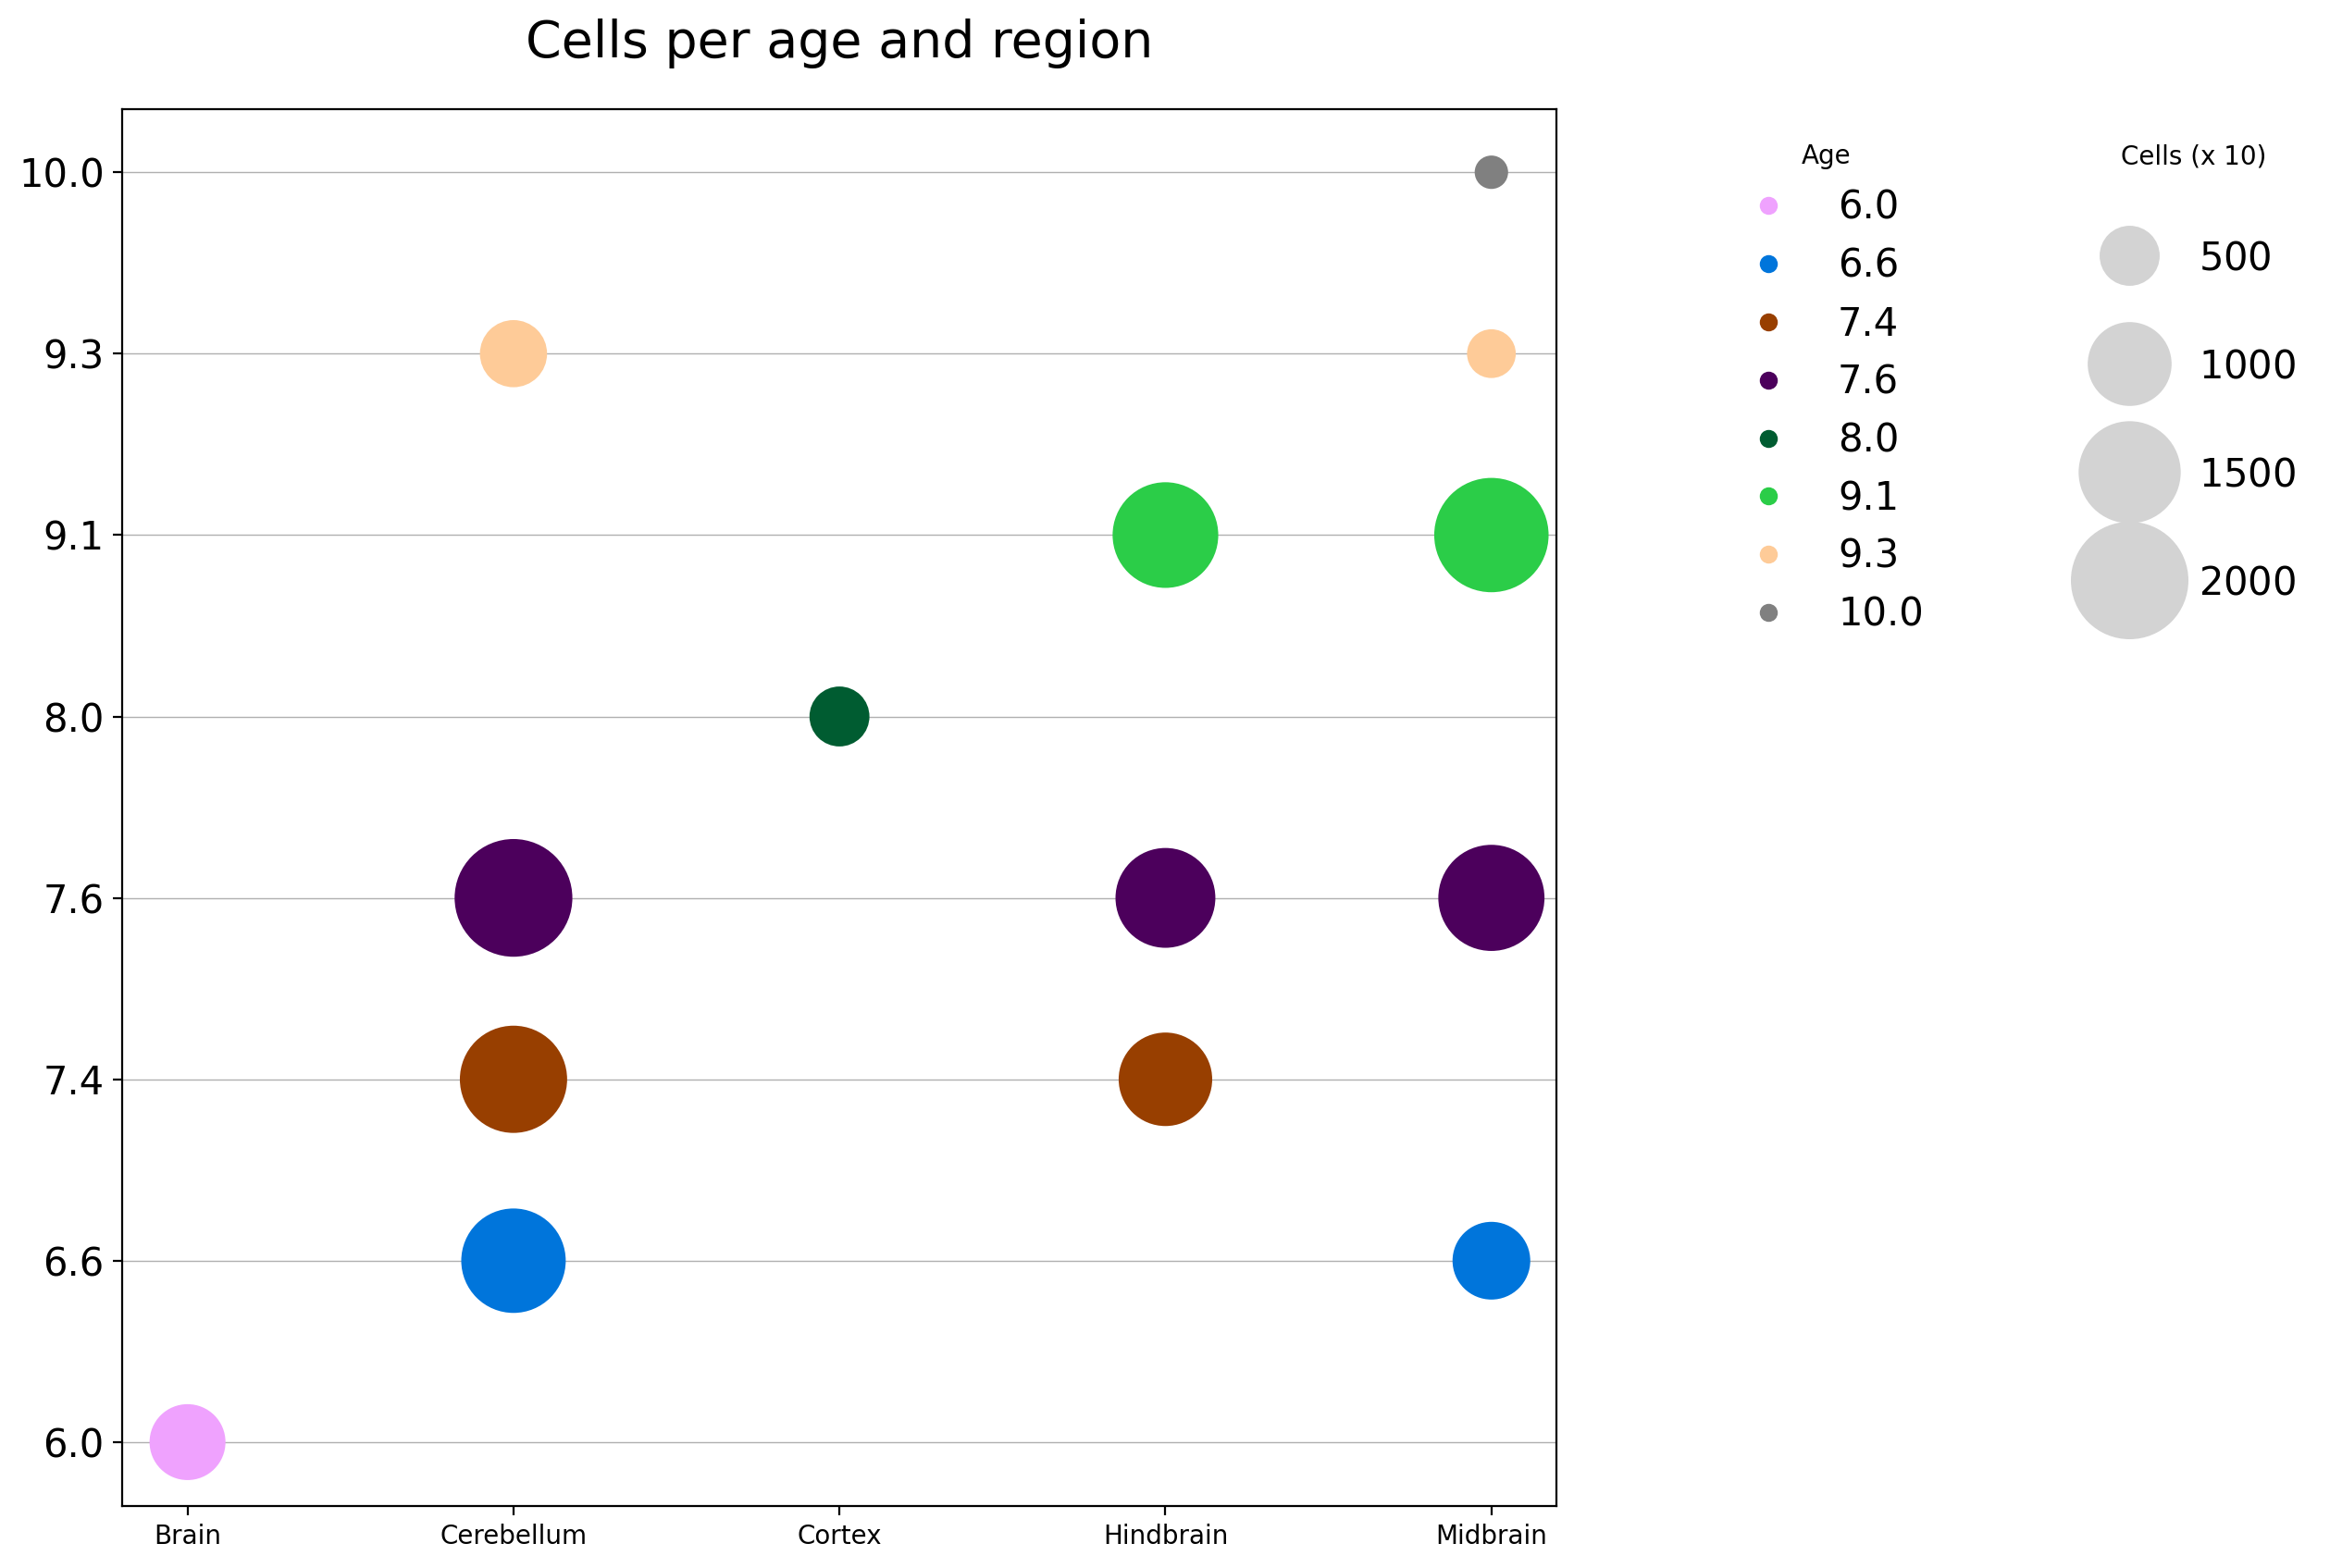

In [56]:
import pandas as pd

f = '/proj/DEV_ATAC/Build_20210203/All/All.loom'

with loompy.connect(f, 'r') as ds:

    tissue = np.unique(ds.ca.Tissue) 
    ages = np.unique(ds.ca.Age)
    df = pd.DataFrame([])

    for i, t in enumerate(tissue): 
        age, cells = np.unique(ds.ca.Age[ds.ca.Tissue == t], return_counts=True)

        data = pd.DataFrame({'Regions': t, 'Age': age, 'Bubble_size': cells/10},
        columns=['Regions', 'Age', 'Bubble_size'])
        df = df.append(data)
    
    order = sorted(np.unique(df['Age']))
    df['Age'] = [order.index(x) for x in df['Age']]
    df = df.set_index(np.arange(0,df.shape[0])) 
    color = colorize(df.Age) 
    colors = colorize(ages)

    fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
    h = lambda c: plt.Line2D([], [], color=c, ls="", marker="o")

    scatter = ax.scatter('Regions', 'Age', c=color, s='Bubble_size', data=df)
    legend1 = ax.legend(handles=[h(colors[i]) for i in range(len(ages))], labels=list(order), 
                        bbox_to_anchor=(0.73, 0., 0.55, 1.0), title='Age', title_fontsize=10, frameon=False, fontsize=15)
    ax.add_artist(legend1)
    handles, labels = scatter.legend_elements(prop="sizes", num=5, color='lightgrey') 
    legend2 = ax.legend(handles, labels, bbox_to_anchor=(0.79, 0., 0.75, 1.0), 
                        labelspacing=1.8, title="Cells (x 10)", title_fontsize=10, frameon=False, fontsize=15)
#     plt.xticks(rotation=45, fontsize=15) 
    plt.yticks(range(len(order)), order, fontsize=10) 
    plt.yticks(fontsize=15) 
    ax.yaxis.grid(b=None, which='major', linewidth=0.5) 
    ax.set_axisbelow(True) 
    plt.title('Cells per age and region', fontsize=20, pad=20)

    plt.savefig('/home/camiel/output_figures/Build_20210203_All_sampling.png', bbox_inches='tight')

182184

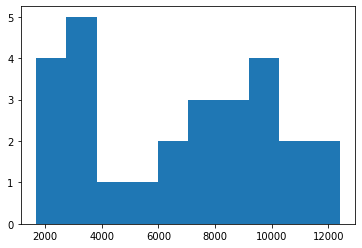

In [4]:
samples = ['232_1', '232_2', '232_3', '232_4', '242_1', '242_2', '242_3', '242_4', '250_1', '250_2', '250_3', '250_4', 
           '279_1', '279_2', '279_3', '280_1', '280_2', '280_3', '282_3', '286_1', '286_2', '286_7', '286_8', '290_1', 
           '290_2', '291_2', '291_3']

cells = []

for sample in samples:
    f = os.path.join(config.paths.samples, f'10X{sample}', f'10X{sample}_20kb.loom')
    with loompy.connect(f, 'r') as ds:
        cells.append(ds.shape[1])

plt.hist(cells)
np.sum(cells)

In [14]:
f = '/proj/DEV_ATAC/Build_20210203/Brain/Brain_peaks.loom'
temporary_aggregate = '/proj/DEV_ATAC/Build_20210203/Whole_brain/Brain_tmp.agg.loom'

with loompy.connect(f) as ds:
    print(ds.ra.keys())

['Annotation', 'Chr', 'CpG%', 'Detailed Annotation', 'Distance to TSS', 'End', 'Entrez ID', 'Focus Ratio-Region Size', 'GC%', 'Gene Alias', 'Gene Description', 'Gene Name', 'Gene Type', 'ID', 'NCells', 'Nearest Ensembl', 'Nearest PromoterID', 'Nearest Refseq', 'Nearest Unigene', 'Peak Score', 'Start', 'Strand', 'Valid', 'mu', 'sd']


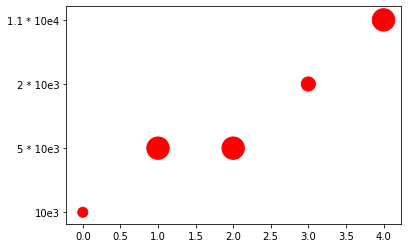

In [57]:
import numpy as np
import pandas as pd

# d = {'id': np.array([0,1,2,3,4]), 'scale': np.array(['10e3', '5 * 10e3', '10e4', '5 * 10e4', '10e5']), 'size': np.array([1000, 5000, 10000, 50000, 100000])}
# d = {'id': np.array([0,1,2,3,4]), 'scale': np.array(['10e3', '5 * 10e3', '5 * 10e3', '2 * 10e3', '10e4']), 'size': np.array([1000, 5000, 5000, 2000, 10000])}
# d = {'id': np.array([0,1,2,3,4]), 'scale': np.array(['10e3', '5 * 10e3', '5 * 10e3', '2 * 10e3', '9 * 10e3']), 'size': np.array([1000, 5000, 5000, 2000, 9000])}
d = {'id': np.array([0,1,2,3,4]), 'scale': np.array(['10e3', '5 * 10e3', '5 * 10e3', '2 * 10e3', '1.1 * 10e4']), 'size': np.array([1000, 5000, 5000, 2000, 5000])}


d['Bubble_size'] = d['size'] / 10

df = pd.DataFrame.from_dict(d)
plt.scatter('id', 'scale', c='red', s='Bubble_size', data=df)


1.0


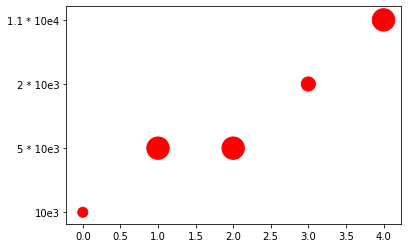

In [58]:
X = np.round(np.log10(np.max(d['size']))) - 3
print(X)
d['Bubble_size'] = d['size'] / 10**X

df = pd.DataFrame.from_dict(d)
plt.scatter('id', 'scale', c='red', s='Bubble_size', data=df)

In [59]:
10**X

10.0